# Data Preparation, Partion, Trainning and Evaluation
This notebook loads the previously cleaned data with the *additionnal metrics*, prepares it, partitions it and trains it using logistic regression and Random Forest 
## 1. Data Preparation
In this first step, we'll load and prepare our data.
### 1.1. Feature Selection

In [3]:
# Inline plotting for Jupyter Notebooks
%matplotlib inline  

# General imports
import os
import re
import glob
import random
from collections import Counter, defaultdict
from pathlib import Path

# Numerical and data handling libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Preprocessing and resampling techniques
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import (
   StandardScaler,
   LabelEncoder,
   label_binarize)

# Machine Learning models and utilities
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Metrics and evaluation tools
from sklearn.metrics import (
    classification_report,
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support
)
from sklearn.utils import resample, compute_class_weight

# Data splitting and validation
from sklearn.model_selection import StratifiedKFold, train_test_split


In order to simplify repertory changes, we'll initialize two variables, containning the paths of this current repository and the path of your clone of the Apache Hive repertory.

In [4]:
project_repo = Path("/home/nicolasrichard/Desktop/Apache_Hive_Bug_Prediction_ML_Model")

In [5]:
def extract_version(filename):
    file_part = filename.split('/')[-1]

    parts = file_part.split('_')
    if len(parts) < 2:
        raise ValueError("Filename does not contain a version segment.")

    version_part = parts[1].split('_')[0]
    return version_part

In [6]:
input_files = glob.glob(os.path.join(project_repo, 'UND_hive_additional_metrics', '*.csv'))

concatenated_df = pd.DataFrame()

reference_columns = pd.read_csv(input_files[0], low_memory=False).columns

for file in input_files:

    df = pd.read_csv(file, low_memory=False)
    df.columns = df.columns.str.strip()

    df = df[reference_columns]

    version = extract_version(file)
    df.insert(loc=2, column='Version', value=version)

    concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)

concatenated_df = concatenated_df.loc[:, ~concatenated_df.columns.duplicated()]


In [7]:
print("\nAll column names in the concatenated DataFrame:")
for i, column in enumerate(concatenated_df.columns, start=1):
    print(f"{i}: {column}")


All column names in the concatenated DataFrame:
1: Bug
2: FileName
3: Version
4: Priority
5: AvgCountLine
6: AvgCountLineBlank
7: AvgCountLineCode
8: AvgCountLineComment
9: AvgCyclomatic
10: AvgCyclomaticModified
11: AvgCyclomaticStrict
12: AvgCyclomaticStrictModified
13: AvgEssential
14: CCViolDensityCode
15: CCViolDensityLine
16: CountCCViol
17: CountCCViolType
18: CountClassBase
19: CountClassCoupled
20: CountClassCoupledModified
21: CountClassDerived
22: CountDeclClass
23: CountDeclClassMethod
24: CountDeclClassVariable
25: CountDeclExecutableUnit
26: CountDeclFile
27: CountDeclFileCode
28: CountDeclFileHeader
29: CountDeclFunction
30: CountDeclInstanceMethod
31: CountDeclInstanceVariable
32: CountDeclInstanceVariablePrivate
33: CountDeclInstanceVariableProtected
34: CountDeclInstanceVariablePublic
35: CountDeclMethod
36: CountDeclMethodAll
37: CountDeclMethodConst
38: CountDeclMethodDefault
39: CountDeclMethodFriend
40: CountDeclMethodPrivate
41: CountDeclMethodProtected
42: Coun

Below, we'll just reorder our dataframe by column, including the 55 original columns (the *46 independent variables* at study (37 related to files, 5 related to classes and 4 related to methods (expanded to 12 for simplicity's sake) mentionned in *Yatish et al., 2019*) in addition to the first column, specify whether there is a bug in a given file. The dataframe is structured as follows) and the 58 additionnal metrics generated. 

In [8]:
concatenated_df.drop_duplicates(inplace=True)

columns_to_keep = (
    [0, 8, 9, 10, 12, 4, 5, 6, 7, 21, 22, 23, 28, 29, 30, 34, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 54, 55, 56, 58, 65, 66, 67, 76, 77, 78, 79, 81, 17, 18, 20, 71, 74, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
    + list(range(95, 153))
)

data = concatenated_df.iloc[:, columns_to_keep]


print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125155 entries, 0 to 125154
Columns: 113 entries, Bug to CommitsWithoutCommentChanges
dtypes: float64(57), int64(56)
memory usage: 107.9 MB
None


### 1.2 Handling NaN and Missing Values

In [9]:
missing_values = data.isnull().sum()
print("\nMissing Values per Column:")
print(missing_values[missing_values > 0])


Missing Values per Column:
CountDeclClassMethod                         449
CountDeclClassVariable                       449
CountDeclInstanceMethod                      449
CountDeclInstanceVariable                    449
CountDeclMethod                              449
CountDeclMethodDefault                       449
CountDeclMethodPrivate                       449
CountDeclMethodProtected                     449
CountDeclMethodPublic                        449
AvgTimeBetweenCommitsInVersion             58000
AvgTimeBetweenCommitsInPreviousVersions    72758
dtype: int64


We'll simply remove the entries where the original Class and Method metrics were not defined. As for the `AvgTimeBetweenCommitsInVersion` and `AvgTimeBetweenCommitsInPreviousVersions` metrics, we'll use the `-1` placeholder to mark these values as undefined

In [10]:
columns_to_check = [
    'CountDeclClassMethod',
    'CountDeclClassVariable',
    'CountDeclInstanceMethod',
    'CountDeclInstanceVariable',
    'CountDeclMethod',
    'CountDeclMethodDefault',
    'CountDeclMethodPrivate',
    'CountDeclMethodProtected',
    'CountDeclMethodPublic'
]

data = data.dropna(subset=columns_to_check)

data['AvgTimeBetweenCommitsInVersion'] = data['AvgTimeBetweenCommitsInVersion'].fillna(-1)
data['AvgTimeBetweenCommitsInPreviousVersions'] = data['AvgTimeBetweenCommitsInPreviousVersions'].fillna(-1)

In [11]:
X = data.drop('Bug', axis=1)
y = data['Bug']

print("\nClass Distribution:")
print(y.value_counts())

print("\nVariables Information:")
print(X.info())
missing_values = X.isnull().sum()
print("\nMissing Values per Column:")
print(missing_values[missing_values > 0])


Class Distribution:
Bug
0    122160
1      2546
Name: count, dtype: int64

Variables Information:
<class 'pandas.core.frame.DataFrame'>
Index: 124706 entries, 0 to 125154
Columns: 112 entries, AvgCyclomatic to CommitsWithoutCommentChanges
dtypes: float64(57), int64(55)
memory usage: 107.5 MB
None

Missing Values per Column:
Series([], dtype: int64)


### 1.3.Outlier Detection and Handling
Before we split our dataframe, we'll get rid of the outliers within our data

In [12]:
numeric_features = data.select_dtypes(include=['float64']).columns.tolist()

def remove_outliers(df, numeric_cols, std_threshold=3):
    df_clean = data.copy()
    
    for col in numeric_cols:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        df_clean = df_clean[abs(df_clean[col] - mean) <= std_threshold * std]
    
    return df_clean

data_no_outliers = remove_outliers(data, numeric_features)

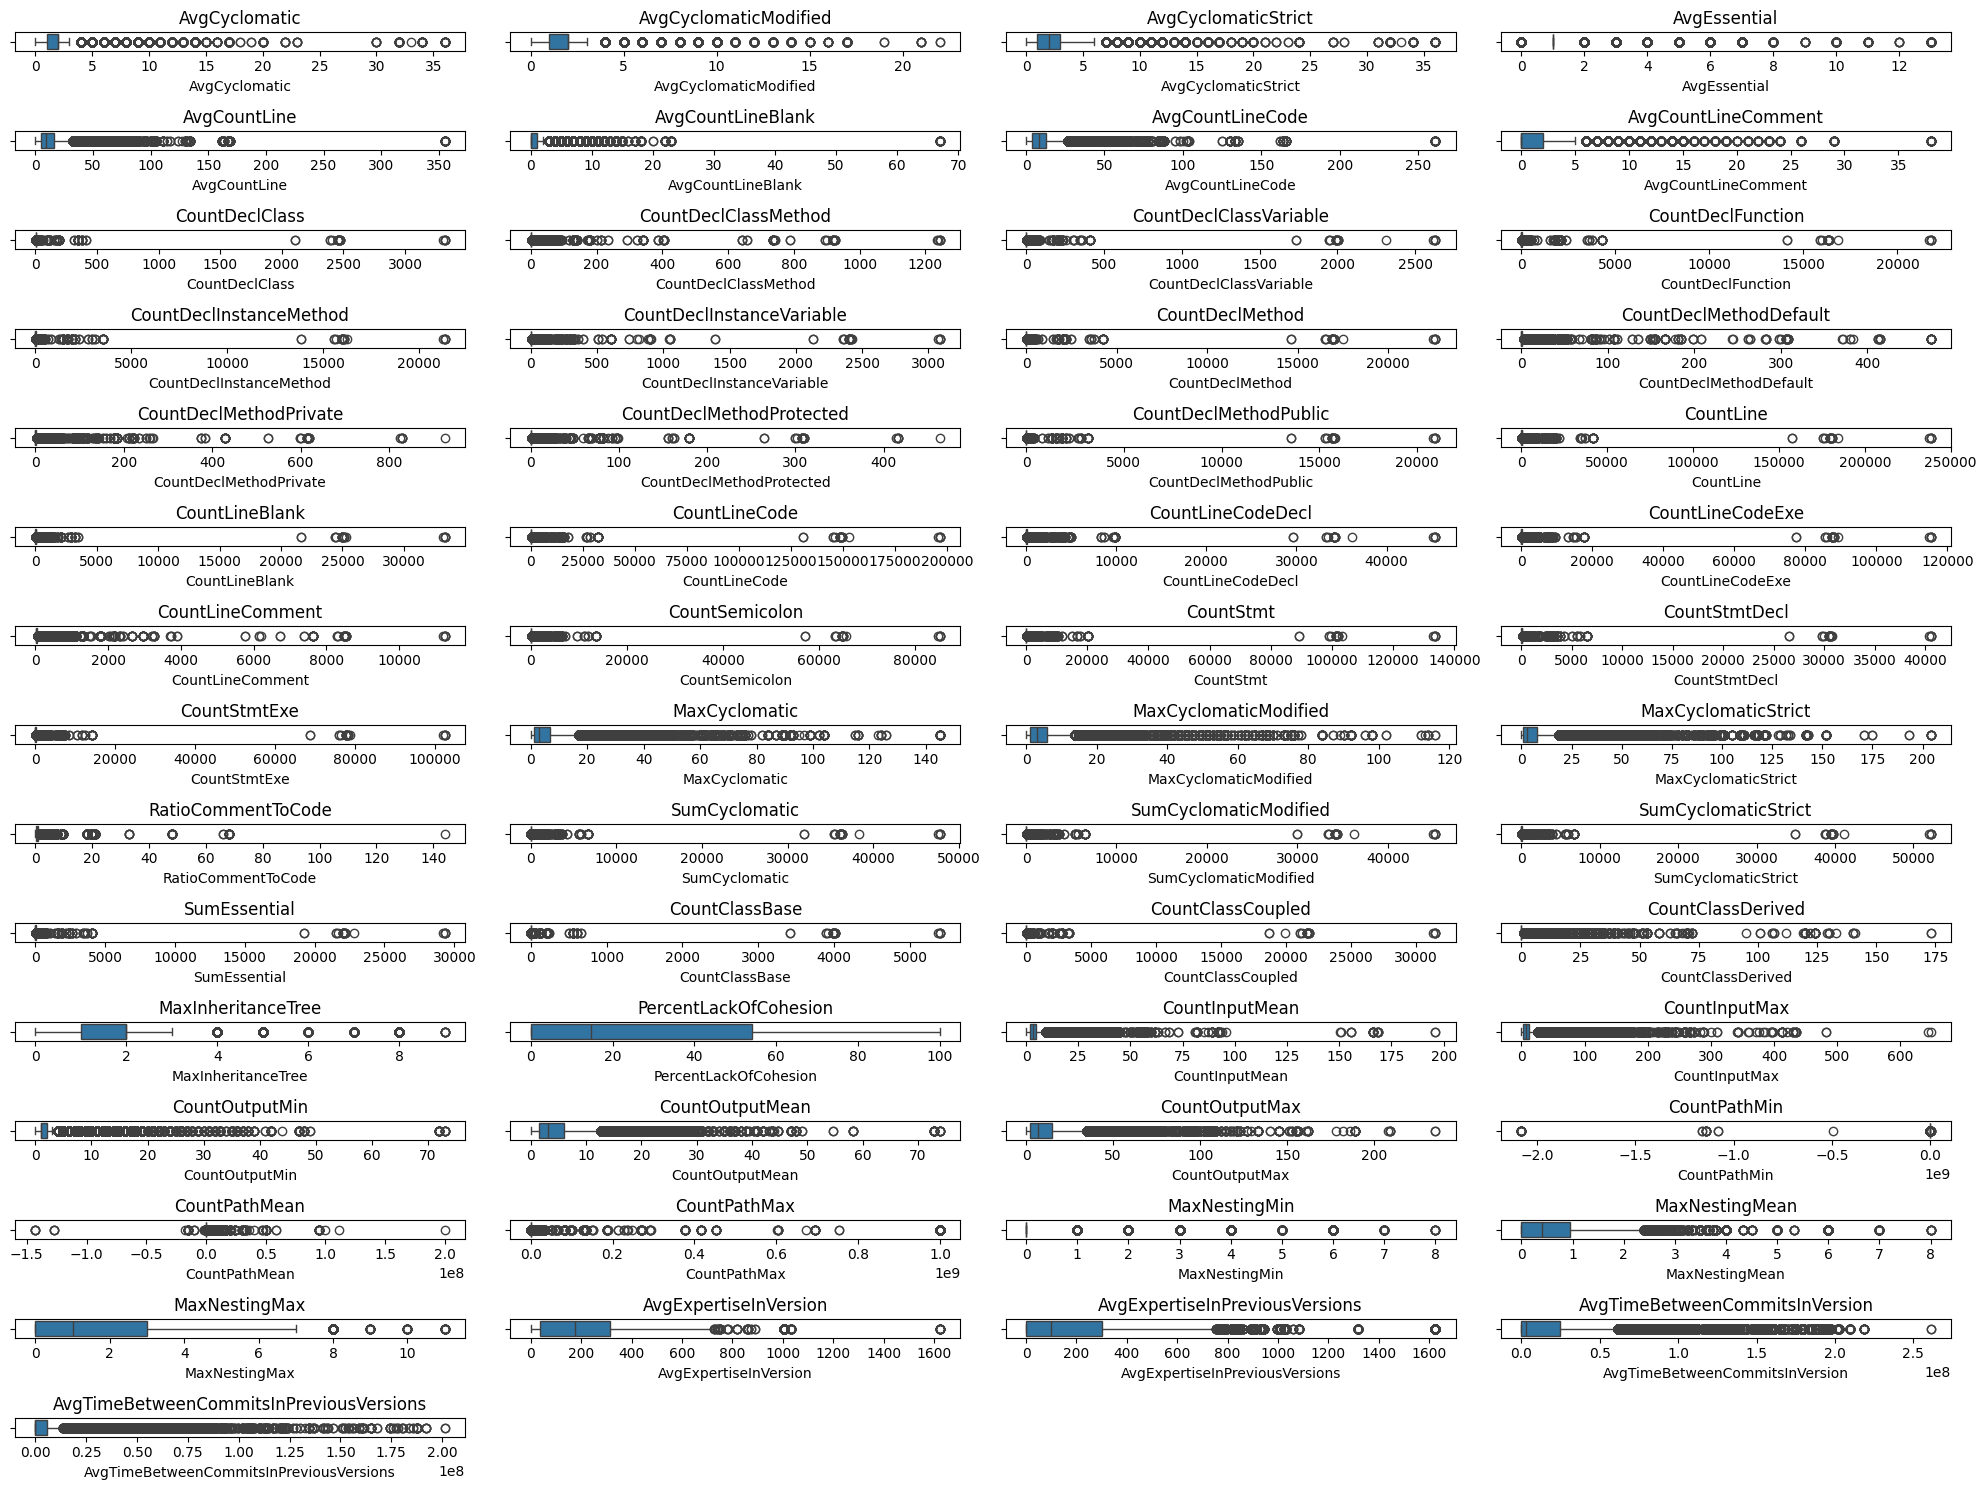

In [13]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(15, 4, i)
    sns.boxplot(x=data[feature])
    plt.title(f'{feature}')
plt.tight_layout()
plt.show()

In [14]:
X = data.drop('Bug', axis=1)
y = data['Bug']

X_no_outliers = data_no_outliers.drop('Bug', axis=1)
y_no_outliers = data_no_outliers['Bug']


print("Class distribution for data with outliers :")
print(y.value_counts())
print("Class distribution for data without outliers :")
print(y_no_outliers.value_counts())


Class distribution for data with outliers :
Bug
0    122160
1      2546
Name: count, dtype: int64
Class distribution for data without outliers :
Bug
0    48224
1      356
Name: count, dtype: int64


Considering the above data, we can observe that the vast majority of the files containning bugs do also contain outliers. Hence, they will not be removed

## 2. Data Partitionning and  Correlation Analysis
Here, we want to remove correlated features in ou trainning set and to identify and remove highly correlated features before we'll let scikit learn's train_test_split to automatically split and maintain the distribution of classes for the trainning

In [15]:
def drop_highly_correlated_features(X, threshold=0.9):

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    X_reduced = X.drop(columns=to_drop)
    
    return X_reduced, to_drop

X, dropped_features = drop_highly_correlated_features(X, threshold=0.85)

print(f"Dropped {len(dropped_features)} features due to high correlation:")
print(dropped_features)

Dropped 66 features due to high correlation:
['AvgCyclomaticModified', 'AvgCyclomaticStrict', 'AvgCountLineCode', 'CountDeclClassVariable', 'CountDeclFunction', 'CountDeclInstanceMethod', 'CountDeclInstanceVariable', 'CountDeclMethod', 'CountDeclMethodPrivate', 'CountDeclMethodProtected', 'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode', 'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment', 'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe', 'MaxCyclomaticModified', 'MaxCyclomaticStrict', 'SumCyclomatic', 'SumCyclomaticModified', 'SumCyclomaticStrict', 'SumEssential', 'CountClassBase', 'CountClassCoupled', 'LinesAddedSince2.0.1', 'LinesRemovedSince2.0.1', 'LinesAddedSince2.1.1', 'LinesRemovedSince2.1.1', 'LinesAddedSince2.2.0', 'LinesRemovedSince2.2.0', 'LinesAddedSince2.3.10', 'LinesAddedSince2.3.1', 'LinesRemovedSince2.3.1', 'LinesAddedSince2.3.2', 'LinesRemovedSince2.3.2', 'LinesAddedSince2.3.3', 'LinesRemovedSince2.3.3', 'LinesAddedSince2.3

Given the class imbalance, we'll use stratified splitting to maintain the class distribution across all set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,            
    random_state=42       
)

## 3. Over-and-Undersampling
Since our data is heavily imbalanced, we'll need to use an algorithm to oversample our minority class while undersampling the majority class. SMOTE generates synthetic samples for minority classes based on the feature space of the original dataset. It uses a weighted distribution to prioritize minority class examples that are harder to learn.

In [17]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

smote_data = pd.concat([pd.DataFrame(X_smote), pd.Series(y_smote)], axis=1)

majority_class = smote_data[smote_data.iloc[:, -1] == 0]
minority_class = smote_data[smote_data.iloc[:, -1] == 1]

majority_downsampled = resample(majority_class,
                                replace=False, 
                                n_samples=len(minority_class),  
                                random_state=42)

balanced_data = pd.concat([majority_downsampled, minority_class])

X_train_resampled = balanced_data.iloc[:, :-1]
y_train_resampled = balanced_data.iloc[:, -1]

print(Counter(y_train_resampled))

/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Counter({0: 91620, 1: 91620})


## 4. Model Trainning
As per the specification of the project, we want to compare logistic regression and and random forest. We'll use custom class weights. This will allow us to better identify the most and least important variables in our dataset, improve performance of our models while allowing us to still fairly compare our two models.

In [18]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_resampled
)

class_weight_custom = {0: class_weights[0], 1: class_weights[1]}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

thresholds = np.arange(0.500000, 0.999999, 0.00001).tolist()

### 4.1. Logistic Regression
We'll begin by setting up our logistic regression and then we'll proceed to train the model on our data

In [19]:
log_reg = LogisticRegression(
    solver='sag',         
    penalty='l2',          
    max_iter=100_000,         
    n_jobs=-1,             
    random_state=42,
    tol=1e-4,
    class_weight=class_weight_custom    
)

log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('Logistic_Regression', log_reg)
])

In [20]:
log_reg_pipeline.fit(X_train_resampled, y_train_resampled)

y_pred_proba_log_reg = log_reg_pipeline.predict_proba(X_test)[:, 1]

best_threshold, best_precision = max(
    ((t, precision_score(y_test, (y_pred_proba_log_reg >= t).astype(int)))
     for t in thresholds),
    key=lambda x: x[1]
)

y_pred_log_reg = (y_pred_proba_log_reg >= best_threshold).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print(f'Best Threshold: {best_threshold:.2f}')

roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
print(f'AUC Score - Logistic Regression: {roc_auc_log_reg:.2f}')

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log_reg)


Final Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30540
           1       0.42      0.02      0.04       637

    accuracy                           0.98     31177
   macro avg       0.70      0.51      0.52     31177
weighted avg       0.97      0.98      0.97     31177

Best Threshold: 1.00
AUC Score - Logistic Regression: 0.82


### 4.2. Random Forest
Exactly as above, we'll set up our random forest model trainning before testing it

In [21]:
random_forest = RandomForestClassifier(
    n_estimators=1000,
    max_depth=100,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    class_weight=class_weight_custom
)
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('random forest', random_forest)
])

In [22]:
rf_pipeline.fit(X_train_resampled, y_train_resampled)

y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

best_threshold = 0.5
best_precision = 0

for threshold in thresholds:
    y_pred_custom = (y_pred_proba_rf >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_custom)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}")

    if precision > best_precision: 
        best_threshold = threshold
        best_precision = precision  

y_pred_rf = (y_pred_proba_log_reg >= best_threshold).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_rf))

print(f'Best Threshold: {best_threshold}')
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f'AUC Score - Random Forest: {roc_auc_rf:.4f}')


fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)


Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Precision: 0.2290
Threshold: 0.50, Pre

/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.

Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Pre

/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.

Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Pre

/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.

Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000
Threshold: 1.00, Precision: 0.0000

Final Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30540
           1       0.33      0.07      0.12       637

    accuracy                           0.98     31177
   macro avg       0.66      0.53      0.55     31177
weighted avg       0.97      0.98      0.97     31177

Best Threshold: 0.9899299999977703
AUC Score - Random Forest: 0.8892


/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.3. Model Comparison

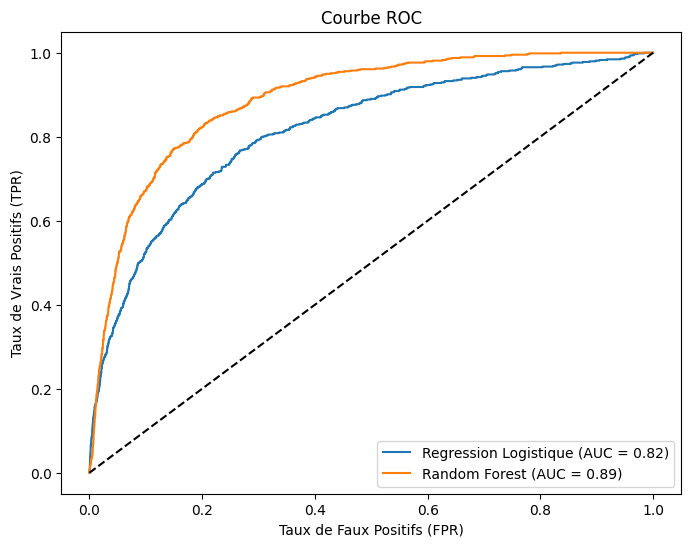

In [23]:
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Regression Logistique (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

## 5. Interpretability of both Models 
In this section, we'll simply graph nomograms for each fo the models trainned above before we'll identify the vaiables of importance in each of the two models. 

### 5.1. Logistic Regression and Random Forest Nomograms
Here are the nomograms for both the models trained

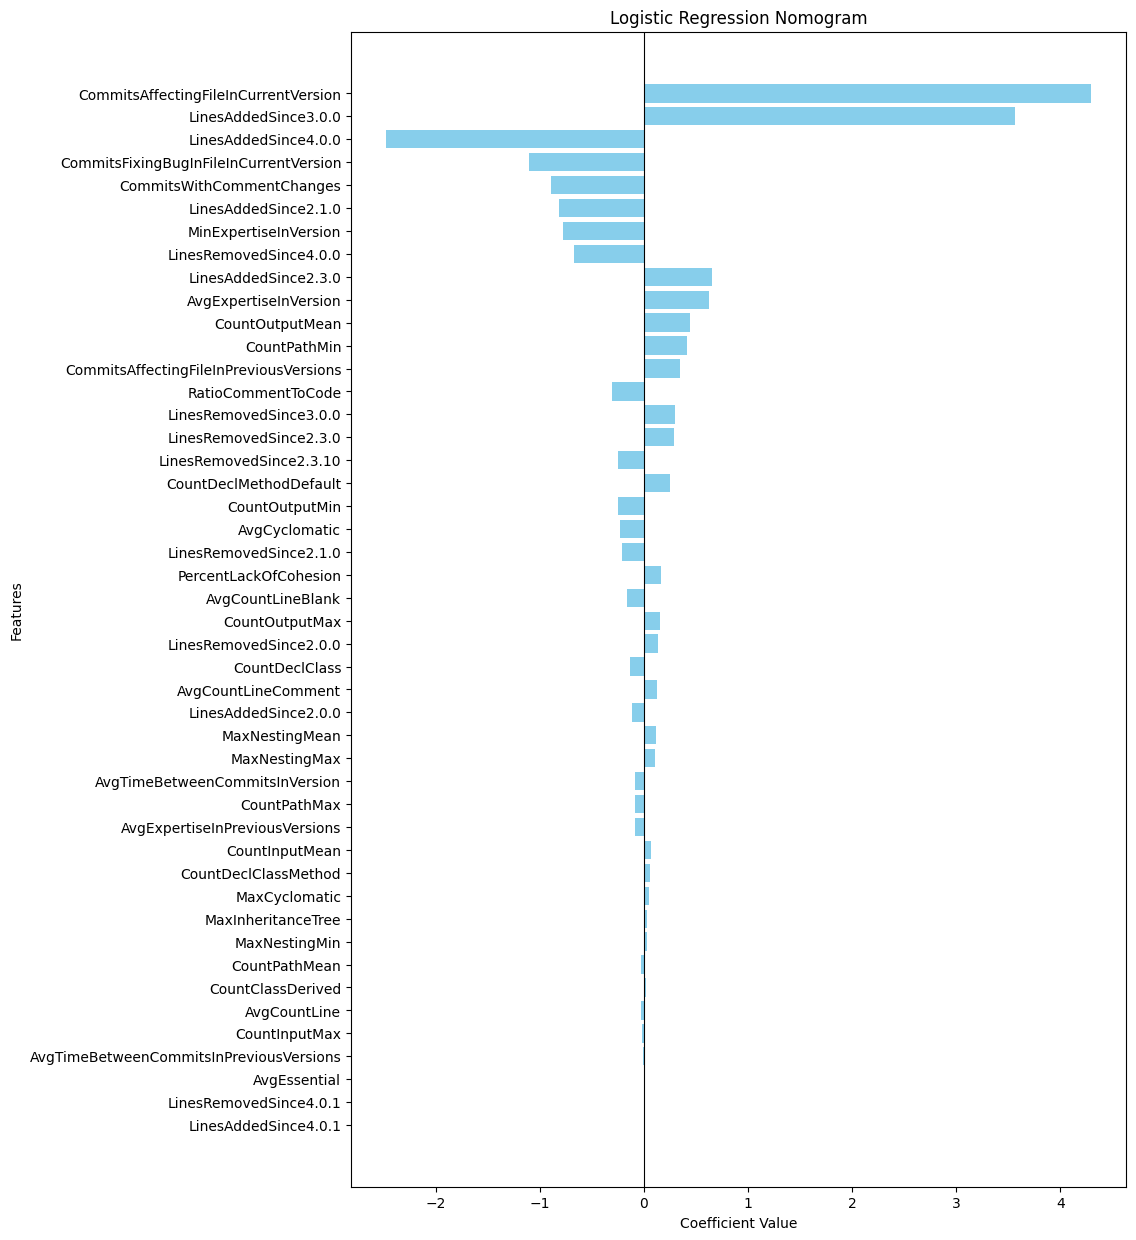

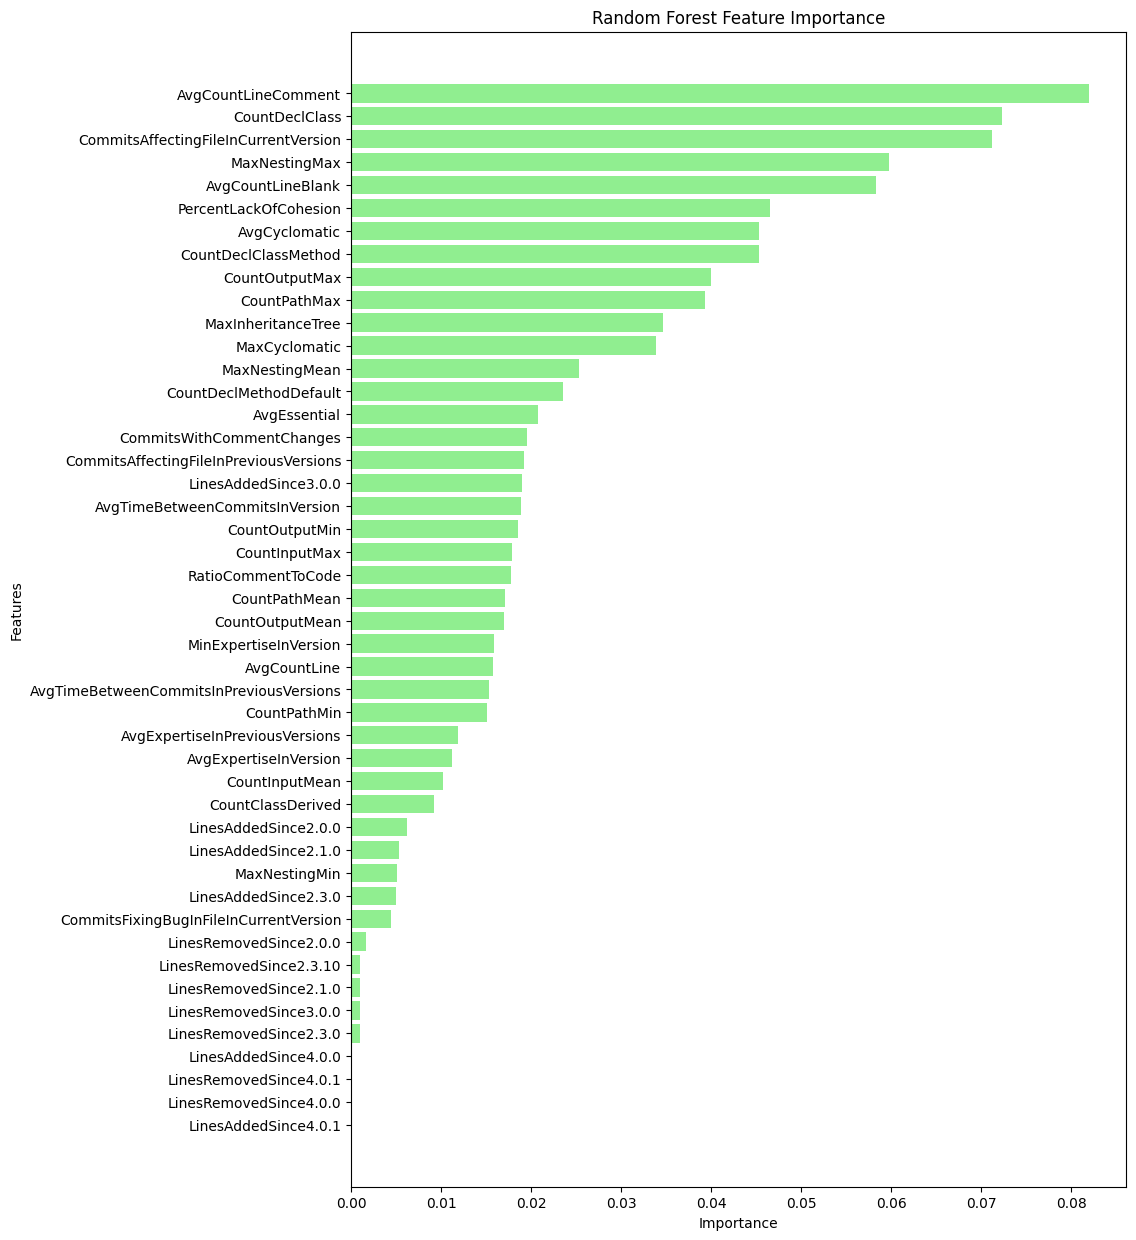

In [24]:
feature_names = X_train_resampled.columns if hasattr(X_train_resampled, 'columns') else [f"Feature {i}" for i in range(X_train_resampled.shape[1])]

log_reg_coefs = log_reg_pipeline.named_steps['Logistic_Regression'].coef_.flatten()
rf_importances = rf_pipeline.named_steps['random forest'].feature_importances_

log_reg_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg_coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 15))
plt.barh(log_reg_df['Feature'], log_reg_df['Coefficient'], color='skyblue')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Logistic Regression Nomogram')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 15))
plt.barh(rf_df['Feature'], rf_df['Importance'], color='lightgreen')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()


### 5.2. Top Features
In this simple graph, we can visualize the relative importance to the model for their top five features

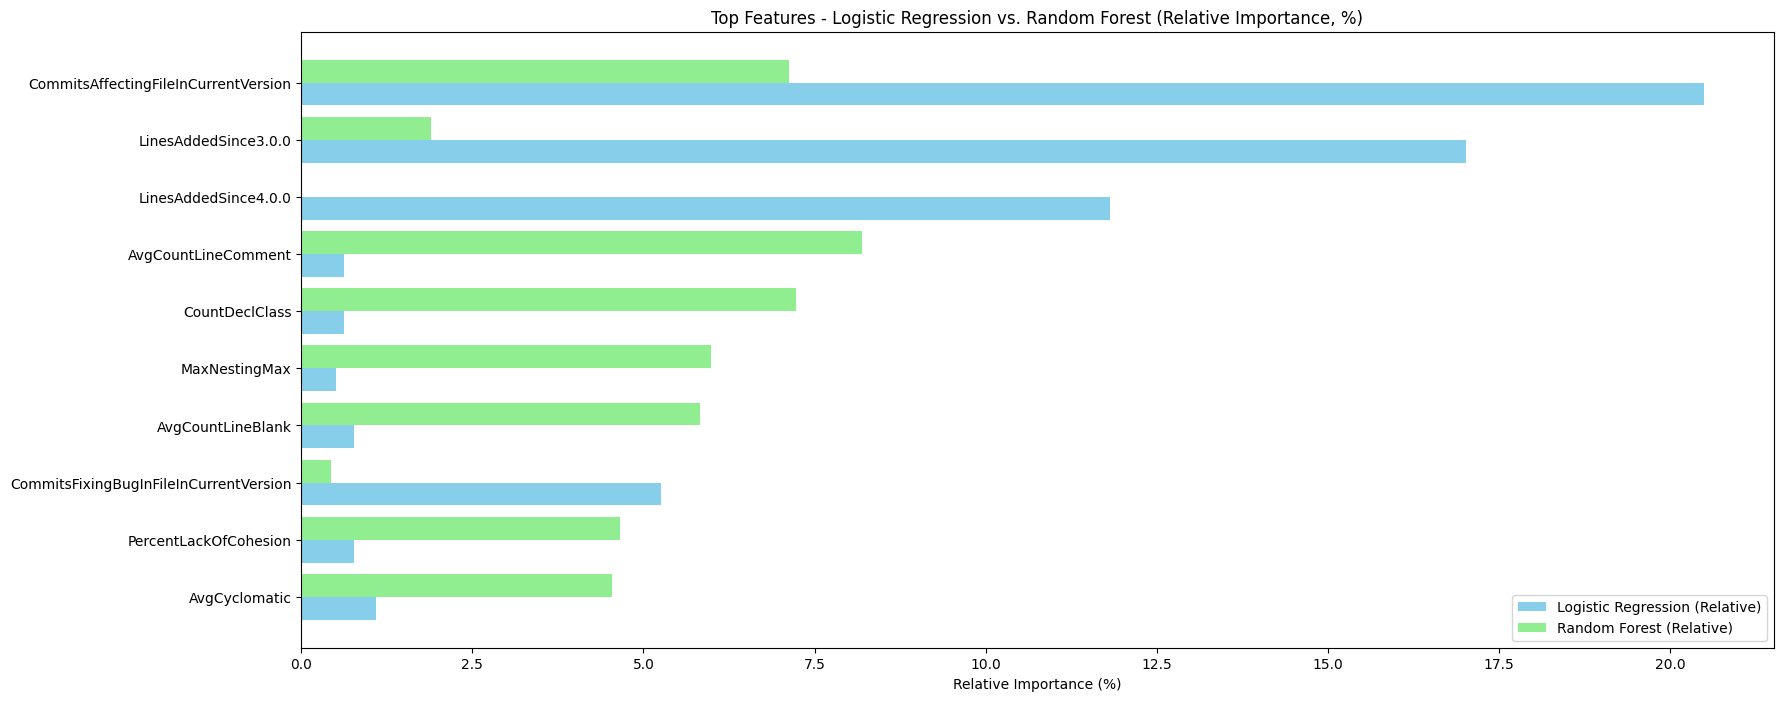

In [25]:
log_reg_coefs = abs(log_reg_pipeline.named_steps['Logistic_Regression'].coef_.flatten())
log_reg_df = pd.DataFrame({
    'Feature': feature_names,
    'Logistic Regression Importance': log_reg_coefs
})

log_reg_df['Logistic Regression Importance'] = 100 * log_reg_df['Logistic Regression Importance'] / log_reg_df['Logistic Regression Importance'].sum()

rf_importances = rf_pipeline.named_steps['random forest'].feature_importances_
rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest Importance': rf_importances
})

rf_df['Random Forest Importance'] = 100 * rf_df['Random Forest Importance'] / rf_df['Random Forest Importance'].sum()

combined_df = log_reg_df.merge(rf_df, on='Feature')
combined_df['Combined Importance'] = combined_df[['Logistic Regression Importance', 'Random Forest Importance']].max(axis=1)
combined_df = combined_df.sort_values(by='Combined Importance', ascending=False).head(10)

plt.figure(figsize=(19, 8))
bar_width = 0.4
x_indices = range(len(combined_df))

plt.barh(
    [x + bar_width for x in x_indices],
    combined_df['Logistic Regression Importance'],
    height=bar_width,
    label='Logistic Regression (Relative)',
    color='skyblue'
)
plt.barh(
    x_indices,
    combined_df['Random Forest Importance'],
    height=bar_width,
    label='Random Forest (Relative)',
    color='lightgreen'
)

plt.yticks([x + bar_width / 2 for x in x_indices], combined_df['Feature'])
plt.xlabel('Relative Importance (%)')
plt.title('Top Features - Logistic Regression vs. Random Forest (Relative Importance, %)')
plt.legend()
plt.gca().invert_yaxis()
plt.show()


## 6. Nominal Regression & Classification 

We'll begin by including and re-processiong ou data using the `Priority` column, that was initally discarded for the above model, instead of the `Bug` variable.

In [26]:
columns_to_keep = (
    [3, 8, 9, 10, 12, 4, 5, 6, 7, 21, 22, 23, 28, 29, 30, 34, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 54, 55, 56, 58, 65, 66, 67, 76, 77, 78, 79, 81, 17, 18, 20, 71, 74, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
    + list(range(95, 153))
)

data = concatenated_df.iloc[:, columns_to_keep]

columns_to_check = [
    'CountDeclClassMethod',
    'CountDeclClassVariable',
    'CountDeclInstanceMethod',
    'CountDeclInstanceVariable',
    'CountDeclMethod',
    'CountDeclMethodDefault',
    'CountDeclMethodPrivate',
    'CountDeclMethodProtected',
    'CountDeclMethodPublic'
]

data = data.dropna(subset=columns_to_check)

data['AvgTimeBetweenCommitsInVersion'] = data['AvgTimeBetweenCommitsInVersion'].fillna(-1)
data['AvgTimeBetweenCommitsInPreviousVersions'] = data['AvgTimeBetweenCommitsInPreviousVersions'].fillna(-1)

Once this is done, we can take care of the `Priority`, our target. We'll add a sixth category, which I called `Bug-Less` for our multinomial and classification models. 

In [27]:
missing_values = data.isnull().sum()
print("\n\n\nMissing Values per Column:")

data['Priority'] = data['Priority'].fillna('Bug-Less')

X = data.drop('Priority', axis=1)
y = data['Priority']

print("\nClass Distribution:")
print(y.value_counts())

print("\nVariables Information:")
print(X.info())

missing_values = X.isnull().sum()
print("\nMissing Values per Column:")
print(missing_values[missing_values > 0])




Missing Values per Column:

Class Distribution:
Priority
Bug-Less    122160
Major         2016
Critical       293
Minor          161
Blocker         69
Trivial          7
Name: count, dtype: int64

Variables Information:
<class 'pandas.core.frame.DataFrame'>
Index: 124706 entries, 0 to 125154
Columns: 112 entries, AvgCyclomatic to CommitsWithoutCommentChanges
dtypes: float64(57), int64(55)
memory usage: 107.5 MB
None

Missing Values per Column:
Series([], dtype: int64)


Now that we have our data, we can persevere with the rest of the data-preparation workflow, as exposed above.

In [28]:
def drop_highly_correlated_features(X, threshold=0.9):
    """
    Drops features from the dataset that are highly correlated above the given threshold.
    """
    X_numeric = X.select_dtypes(include=[np.number])
    corr_matrix = X_numeric.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    X_reduced = X.drop(columns=to_drop)
    return X_reduced, to_drop

X = X.select_dtypes(include=[np.number])
X, dropped_features = drop_highly_correlated_features(X, threshold=0.85)
print(f"Dropped {len(dropped_features)} features due to high correlation:")
print(dropped_features)

print(f"Dropped {len(dropped_features)} features due to high correlation:")
print(dropped_features)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify=y,  
    random_state=42
)

smote = SMOTE(random_state=42, k_neighbors=3)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

smote_data = pd.concat([pd.DataFrame(X_smote), pd.Series(y_smote, name='target')], axis=1)

print("Class distribution after SMOTE:")
print(Counter(y_smote))

min_class_size = smote_data['target'].value_counts().min()

balanced_data = pd.DataFrame(columns=smote_data.columns)
for class_value in smote_data['target'].unique():
    class_subset = smote_data[smote_data['target'] == class_value]
    balanced_data = pd.concat([balanced_data, resample(
        class_subset, 
        replace=False, 
        n_samples=min_class_size, 
        random_state=42
    )])

X_train_resampled = balanced_data.iloc[:, :-1]
y_train_resampled = balanced_data['target']

print("Final class distribution after balancing:")
print(Counter(y_train_resampled))

Dropped 66 features due to high correlation:
['AvgCyclomaticModified', 'AvgCyclomaticStrict', 'AvgCountLineCode', 'CountDeclClassVariable', 'CountDeclFunction', 'CountDeclInstanceMethod', 'CountDeclInstanceVariable', 'CountDeclMethod', 'CountDeclMethodPrivate', 'CountDeclMethodProtected', 'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode', 'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment', 'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe', 'MaxCyclomaticModified', 'MaxCyclomaticStrict', 'SumCyclomatic', 'SumCyclomaticModified', 'SumCyclomaticStrict', 'SumEssential', 'CountClassBase', 'CountClassCoupled', 'LinesAddedSince2.0.1', 'LinesRemovedSince2.0.1', 'LinesAddedSince2.1.1', 'LinesRemovedSince2.1.1', 'LinesAddedSince2.2.0', 'LinesRemovedSince2.2.0', 'LinesAddedSince2.3.10', 'LinesAddedSince2.3.1', 'LinesRemovedSince2.3.1', 'LinesAddedSince2.3.2', 'LinesRemovedSince2.3.2', 'LinesAddedSince2.3.3', 'LinesRemovedSince2.3.3', 'LinesAddedSince2.3

/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE:
Counter({'Bug-Less': 91619, 'Major': 91619, 'Critical': 91619, 'Minor': 91619, 'Blocker': 91619, 'Trivial': 91619})


/tmp/ipykernel_103196/3870624154.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_data = pd.concat([balanced_data, resample(


Final class distribution after balancing:
Counter({'Bug-Less': 91619, 'Major': 91619, 'Critical': 91619, 'Minor': 91619, 'Blocker': 91619, 'Trivial': 91619})


### 6.1 Multinominal Regression (Multinomial Logistic Regression)

We can now procede with the multinomial regression. 


Best Threshold Selected: 1.00
Metrics at Best Threshold:
threshold         0.9991
accuracy          1.0000
precision         1.0000
recall            1.0000
f1_score          1.0000
num_assigned    448.0000
Name: 49910, dtype: float64
              precision    recall  f1-score   support

     Blocker       0.00      0.00      0.00         0
    Bug-Less       1.00      1.00      1.00       448
    Critical       0.00      0.00      0.00         0
       Major       0.00      0.00      0.00         0
       Minor       0.00      0.00      0.00         0
     Trivial       0.00      0.00      0.00         0

    accuracy                           1.00       448
   macro avg       0.17      0.17      0.17       448
weighted avg       1.00      1.00      1.00       448

AUC Score - Multinomial Logistic Regression: 0.73


/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

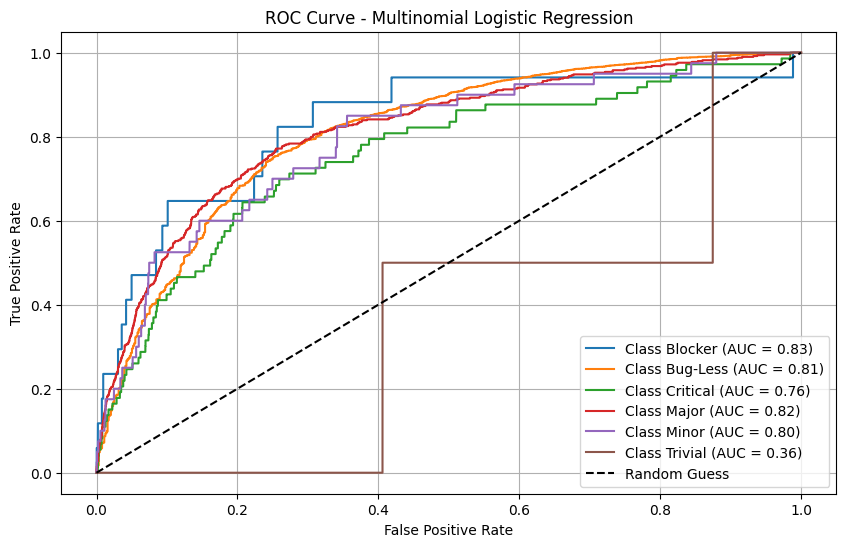

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

unique_classes = np.unique(y_train)
class_to_int = {label: idx for idx, label in enumerate(unique_classes)}
int_to_class = {idx: label for label, idx in class_to_int.items()}

y_train_int = np.array([class_to_int[label] for label in y_train])
y_test_int = np.array([class_to_int[label] for label in y_test])

multinomial_model = LogisticRegression(
    solver='lbfgs',
    penalty='l2',
    max_iter=100_000,
    n_jobs=-1,
    random_state=42,
    tol=1e-4
)

multinomial_model.fit(X_train_scaled, y_train_int)

y_pred_proba = multinomial_model.predict_proba(X_test_scaled)

y_pred_default = np.argmax(y_pred_proba, axis=1)

y_test_binarized = label_binarize(y_test_int, classes=np.unique(y_test_int))

metrics = {
    'threshold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'num_assigned': []
}

thresholds = np.arange(0.500000, 0.999999, 0.00001).tolist()

for threshold in thresholds:
    y_pred_thresh = np.full_like(y_pred_default, fill_value=-1)
    
    max_proba = np.max(y_pred_proba, axis=1)
    y_pred_thresh[max_proba >= threshold] = np.argmax(y_pred_proba[max_proba >= threshold], axis=1)

    valid_indices = y_pred_thresh != -1
    y_true_valid = y_test_int[valid_indices]
    y_pred_valid = y_pred_thresh[valid_indices]

    if len(y_true_valid) == 0:
        accuracy = 0
        precision = 0
        recall = 0
        f1 = 0
    else:
        accuracy = accuracy_score(y_true_valid, y_pred_valid)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true_valid, y_pred_valid, average='weighted', zero_division=0
        )
    
    metrics['threshold'].append(threshold)
    metrics['accuracy'].append(accuracy)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1_score'].append(f1)
    metrics['num_assigned'].append(np.sum(valid_indices))

metrics_df = pd.DataFrame(metrics)

best_threshold_row = metrics_df.loc[metrics_df['f1_score'].idxmax()]
best_threshold = best_threshold_row['threshold']
print(f"\nBest Threshold Selected: {best_threshold:.2f}")
print(f"Metrics at Best Threshold:")
print(best_threshold_row)

y_pred_best_thresh = np.full_like(y_pred_default, fill_value=-1)
max_proba = np.max(y_pred_proba, axis=1)
y_pred_best_thresh[max_proba >= best_threshold] = np.argmax(y_pred_proba[max_proba >= best_threshold], axis=1)

valid_indices = y_pred_best_thresh != -1
y_true_valid = y_test_int[valid_indices]
y_pred_valid = y_pred_best_thresh[valid_indices]

labels = sorted(int_to_class.keys()) 
target_names = [str(int_to_class[i]) for i in labels]

print(classification_report(
    y_true_valid,
    y_pred_valid,
    labels=labels,
    target_names=target_names
))

roc_auc_multinomial = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")
print(f"AUC Score - Multinomial Logistic Regression: {roc_auc_multinomial:.2f}")

plt.figure(figsize=(10, 6))
for i, class_label in enumerate(np.unique(y_test_int)):
    fpr, tpr, _ = roc_curve(
        y_test_binarized[:, i], 
        y_pred_proba[:, i]
    )
    plt.plot(
        fpr, 
        tpr, 
        label=f"Class {int_to_class[class_label]} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]):.2f})"
    )

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multinomial Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 6.2. Classification using Random Forest

We can also use the `RandomForestClassifier` to help with our classification problem. As above, we maintain most of the integristy of our first Random Forest pipeline.


Classification Report (Multiclass):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        17
           1     0.9797    0.9993    0.9894     30541
           2     0.0000    0.0000    0.0000        73
           3     0.1905    0.0079    0.0152       504
           4     0.0000    0.0000    0.0000        40
           5     0.0000    0.0000    0.0000         2

    accuracy                         0.9791     31177
   macro avg     0.1950    0.1679    0.1674     31177
weighted avg     0.9628    0.9791    0.9695     31177



/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nicolasrichard/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)




ROC AUC Score: 0.8612


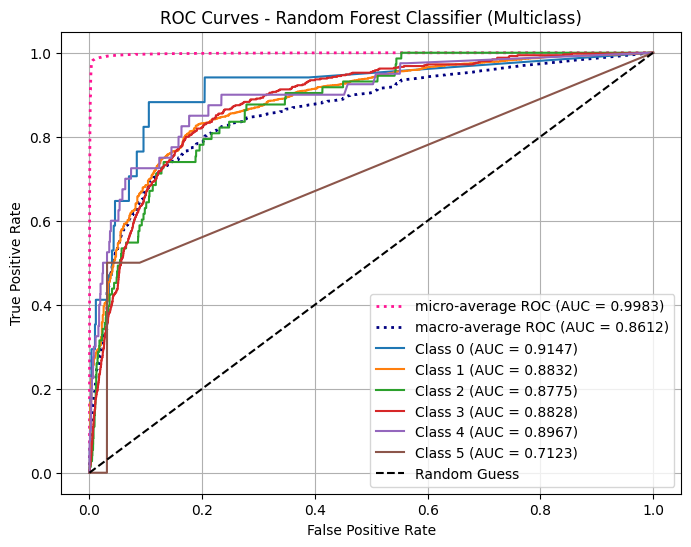

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the model
classification_model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=100,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
classification_model.fit(X_train_scaled, y_train)

y_pred = classification_model.predict(X_test_scaled)

print("\nClassification Report (Multiclass):")
print(classification_report(y_test, y_pred, digits=4))

y_pred_proba = classification_model.predict_proba(X_test_scaled)

n_classes = y_pred_proba.shape[1]
classes = np.unique(y_test)

y_test_binarized = label_binarize(y_test, classes=classes)

fpr = dict()
tpr = dict()
roc_auc_class = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc_class[i] = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc_class["micro"] = roc_auc_score(y_test_binarized, y_pred_proba, average="micro")

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc_class["macro"] = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")

print(f"\n\n\nROC AUC Score: {roc_auc_class['macro']:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (AUC = {roc_auc_class["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC (AUC = {roc_auc_class["macro"]:.4f})',
         color='navy', linestyle=':', linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc_class[i]:.4f})')

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Random Forest Classifier (Multiclass)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()